Thoughts:

How about median aggregating?

Check how many values are aggregated at each step. important!

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
exposed_station = 'Haifa-Atzmaut.csv'
log_interval = 5  # minutes
samples_per_week = int(60 / log_interval * 24 * 7)
start_time = "2013-05-22"
end_time = "2020-05-22"
intervention_time = "2018-02-01"
outcome_pollutant = ['NOX']
predictor_pollutants = ['NOX', 'NO', 'NO2', 'PM2.5', 'CO']
num_controls = len(os.listdir('Data'))-1

In [50]:
def prep_data_station(filename):
    df = pd.read_csv(f'Data/{filename}')
    station_name = df.columns[0]
    df = df.drop(columns=[station_name])
    df = df.rename(columns={colname: colname.strip() for colname in df.columns})
    df = df.rename(columns={df.columns[-1]: 'DateTime'})
    df['DateTime'] = df['DateTime'].apply(lambda x: x.strip().replace('24:00', '00:00'))
    pollutants = list(df)
    pollutants.remove('DateTime')
    units = {colname: df.loc[0, colname].strip() for colname in pollutants}
    df = df.iloc[1:-8]  # Last 8 rows are summary statistics by the EPA, first row is units of measurement
    df[pollutants] = df[pollutants].apply(pd.to_numeric, errors='coerce').clip(0)
    df['DateTime'] = pd.to_datetime(df['DateTime'],infer_datetime_format=True)
    df = df.set_index('DateTime')

    df_roll=df.rolling(window=samples_per_week*2, center=False, min_periods=samples_per_week
              ).mean()[samples_per_week*2::samples_per_week]
    df_roll = df_roll[start_time:end_time]
    y = df_roll[outcome_pollutant].values
    assert(len(y) == 365)  # 7 years (May 2013 to May 2020 inclusive) * 52 plus 1 (datetime is inclusive at both ends)
    x = df_roll.groupby(pd.Grouper(freq='Y')).mean().loc[:intervention_time, predictor_pollutants].values.reshape(-1,1)
    assert(x.shape[0] == len(predictor_pollutants)*5)  # 5 years (2013-2017 inclusive) * 5 predictors
    return y, x, df_roll, units

def prep_data():
    stations = os.listdir('Data')
    stations.remove(exposed_station)
    stations.insert(0, exposed_station)  # make sure exposed unit is first
    Y, X = [], []
    for station in stations:
        y, x, df_roll, units = prep_data_station(station);
        Y.append(y)
        X.append(x)
        if station == exposed_station:
            df_haifa = df_roll[outcome_pollutant].copy()
        print(f'Finished extracting data from {station[:-4]}')
    return np.hstack(Y), np.hstack(X), df_haifa, units


Y, X, df_haifa, units = prep_data()

Finished extracting data from Haifa-Atzmaut
Finished extracting data from Raanana
Finished extracting data from Jerusalem-BarIlan
Finished extracting data from TelAviv-IroniD
Finished extracting data from Rashlatz


In [23]:
# There are nans, need to see if the fitting functions deal with them ok:
[np.sum(np.isnan(Y[:,i])) for i in range(Y.shape[1])]

[4, 7, 2, 7, 10]

In [71]:
def plot_outcome(df_haifa, synthetic_outcome):
    df_haifa = df_haifa.rename(columns={outcome_pollutant[0]:f'Real {outcome_pollutant[0]} Haifa'})
    df_haifa[f'Synthetic {outcome_pollutant[0]} Haifa'] = synthetic_outcome
    ax=df_haifa.plot(figsize=(8, 8));
    ax.grid()
    ax.set_ylabel(f'{outcome_pollutant[0]} [{units[outcome_pollutant[0]]}]')
    ax.axvline(intervention_time, color='m', ls='--', lw=3)
    ax.text(s='LEZ implementation', x=intervention_time, y=100, size=12, color='m');

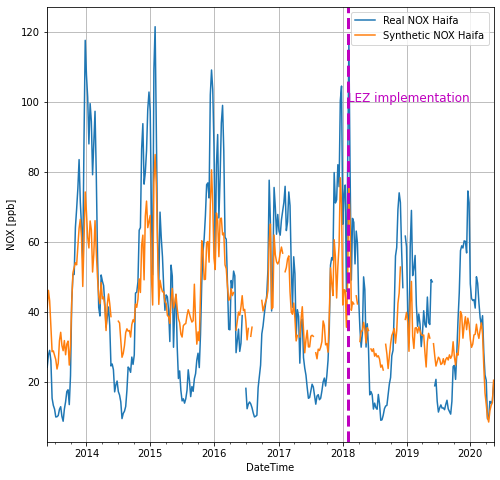

In [72]:
# The most simple linear regression of X - unweighted predictors, raw data
W = np.linalg.lstsq(X[:,1:], X[:,0,None], rcond=None)[0]
synthetic_outcome = Y[:,1:].dot(W)
plot_outcome(df_haifa, synthetic_outcome)

In [ ]:
# Model 2
W2 = None
synthetic_outcome = Y[:,1:].dot(W2)
plot_outcome(df_haifa, synthetic_outcome)